In [1]:
# import
from hsflfm.config import home_directory
from hsflfm.util import load_graph_images, load_dictionary, generate_A_matrix, MetadataManager
from hsflfm.calibration import CalibrationInfoManager, SystemVertexParser, SystemCalibrator, FLF_System

import os 
import numpy as np
from PIL import Image 
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

import matplotlib

Step 1: Parse Vertices

In [2]:
# calibration filename can be manually specified or pulled from stored metadata 
specimen = "20250226_OB_2"
mm = MetadataManager(specimen)
calibration_filename = mm.calibration_filename
calibration_folder = mm.calibration_folder

info_manager = CalibrationInfoManager(calibration_filename)

In [3]:
# known information 
info_manager.vertex_spacing_m = 500e-6
info_manager.pixel_size = 52e-6

info_manager.save_all_info()

In [4]:
# give the manager enough information to find the graph images
# this may need to be changed if different naming conventions were used 
# the dictionary just needs to contain a substring that is unique to the specific plane image

plane_names = np.sort([i for i in os.listdir(calibration_folder) if "tiff" in i])
name_dict = {}
for i, name in enumerate(plane_names):
    name_dict[i] = name 
info_manager.plane_names = name_dict 

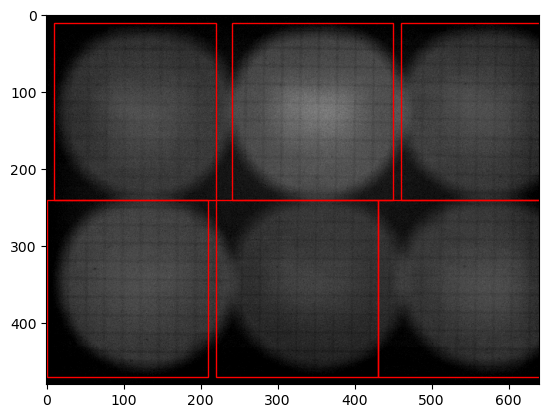

In [8]:
# load one image to identify where images should be cropped
# right now functions are only tested with the default provided crops
# and crops are expected to be the same size for all cameras

# standard crops for 3 camera system
crop_indices = {
    0: [230, 480, 0, 200],
    1: [230, 480, 440, 640],
    2: [0, 250, 220, 420],
}

# standard crops for 6 camera system 
# crop_indices = {
#     0: [20, 250, 0, 210], 
#     1: [250, 480, 0, 210],
#     2: [20, 250, 220, 430], 
#     3: [250, 480, 220, 430],
#     4: [20, 250, 430, 640], 
#     5: [250, 480, 430, 640]
# }

crop_indices = {
    0: [10, 240,10, 220], 
    1: [240, 470, 0, 210],
    2: [10, 240, 240, 450], 
    3: [240, 470, 220, 430],
    4: [10, 240, 460, 640], 
    5: [240, 470, 430, 640]
}

# this could be done with any image, including of an ant
image_filename = calibration_folder + '/' + plane_names[0] 
raw_image = Image.open(image_filename)
plt.imshow(raw_image)
ax = plt.gca()
for c in crop_indices.values():
    rect = Rectangle((c[2], c[0]), c[3] - c[2], c[1] - c[0], fill=False, color='red')
    ax.add_artist(rect)

In [ ]:
info_manager.crop_indices = crop_indices
info_manager.save_all_info()

In [ ]:
# load all the images
all_images = load_graph_images(folder=calibration_folder, calibration_filename=calibration_filename)

In [ ]:
# view one image to get the expected spacing between lines
plt.figure()
plt.imshow(all_images[0][0])
plt.colorbar()

In [ ]:
expected_spacing = 160 - 135

In [ ]:
parser = SystemVertexParser(calibration_filename, expected_vertex_spacing=expected_spacing, all_images=all_images)

In [ ]:
# use this cell to adjust threshold values
# see the README in the calibration folder
# for more info on settings these values  
threshold_values = {
    # used in "cv2.adaptiveThreshold" to convert graph images to binary images
    # should be an odd number that approximately matches the expected spacing
    "adaptive_threshold_range": 23,
    # used in cv2.medianBlur to filter the binary image
    # larger numbers will blur out smaller features in the image other than the
    # graph lines we are trying to identify
    "blur_range": 3,
    # "edge_thresh" and "edge_aperture" are used in cv2.Canny
    # to identify edges in the images. 
    # consult cv2 documentation for use
    "edge_thresh1": 100,
    "edge_thresh2": 140,
    "edge_aperture": 5,
    # line_thresh_per_pixel * #pixel used in cv2.HoughLines to 
    # identify lines from edges
    "line_thresh_per_pixel": 0.45,
}

camera_number = 4
plane_number = 4
parser.find_lines(camera_number, plane_number, show=True, threshold_values=threshold_values,
                  show_process=True)

In [ ]:
parser.find_all_remaining_lines(show=False, max_display=1000)
parser.save_all_parameters()

In [ ]:
# for "ValueError: cannot convert float NaN to integer"
# just pick a different camera number or plane number to look at
parser.find_vertices(camera_number=4, plane_number=0, show=True)

In [ ]:
# parser.debug_missing_point(4, 0, (80, 170))

In [ ]:
parser.find_all_remaining_vertices(show=False, max_display=200)
parser.remove_nan_points() 
parser.save_all_parameters()

Step 2: Remove extraneous vertices

While this step can be improved in future versions, right now extraneous vertices must be manually removed, or they will impact the calibration results. This can be done by running ``remove_vertices.py`` (first open the file and adjust necessary settings, particularly the file names). 

Step 3: identify approximate alignment points between images

This step can likely be automated in future versions of the code, but right now the user must manually select approximate alignment points between the images. This can be done by finding a feature visible in all 48 images, then running ``select_alignment_points.py`` to click on that point in all the images. 

Step 4: Fit calibration coefficients

In this portion, the identified graph vertices are used to perform inter- and intr-camera calibration

In [ ]:
# this can be uncommented to display interactive plots
# %matplotlib notebook

In [ ]:
reference_camera = 2

In [ ]:
# select reference plane based on how many vertices were identified in each plane
# the first number gives the total number of vertices identified in a given plane 
# between all images
# and the second number is the number of identified vertices in the image with the 
# least identified vertices.
# both of these numbers should be reasonably large in the chosen reference plane
vertices = load_dictionary(calibration_filename)['all_vertices']

for plane_num, values in vertices.items():
    plane_points = 0
    min_points = np.inf
    for cam, points in values.items():
        plane_points = plane_points + len(points) 
        min_points = min(min_points, len(points))
    print(plane_num, "total points:", plane_points, ", mininum points in an image:", min_points)

In [ ]:
reference_plane = 2

In [ ]:
plane_separation_mm = 0.381
calibrator = SystemCalibrator(
    calibration_filename=calibration_filename,
    reference_plane=reference_plane,
    reference_camera=reference_camera,
    plane_separation_mm = plane_separation_mm,
    ref_plane_image_folder = None,
    useable_plane_numbers = None # if None, this will use all planes
)

In [ ]:
calibrator.run_inter_camera_calibration(show=True, order=2)

In [ ]:
calibrator.run_slope_calibration(show=True, order=1)

In [ ]:
%debug



Step 5: check if results look reasonable

In [ ]:
system = FLF_System(calibration_filename)
all_camera_vertices_matrices = calibrator.all_camera_vertices_matrices

In [ ]:
def make_comparison_plot(camera_number, vector_length_mm=None):
    slope0, slope1 = calibrator.get_slopes_from_vertices_matrices(camera_number)
    vertices_matrices = all_camera_vertices_matrices[camera_number]

    plt.figure()
    matrix_shape = vertices_matrices.shape[1:3] 
    first = True
    for i, j in np.ndindex(matrix_shape):
        if first:
            label1 = "Comptuted slope vector"
            label2 = "Fit slope"
            label3 = "Vertex locations"
        else:
            label1 = None
            label2 = None
            label3 = None
                
        X = vertices_matrices[:, i, j, 0]
        Y = vertices_matrices[:, i, j, 1] 
            
        if not np.isnan(slope0[i, j]):
            if vector_length_mm is None:
                start_plane_mm = (np.where(~np.isnan(X))[0][0] - system.reference_plane) * plane_separation_mm
                end_plane_mm = (np.where(~np.isnan(X))[0][-1] - system.reference_plane) * plane_separation_mm
            else:
                start_plane_mm = -vector_length_mm / 2
                end_plane_mm = vector_length_mm / 2

            x = vertices_matrices[system.reference_plane, i, j, 0]
            y = vertices_matrices[system.reference_plane, i, j, 1]
            
            # plot the slope vector that was fit to that point 
            coeff0, coeff1 = system._get_slope_coeffs(camera_number)
            slope_matrix = generate_A_matrix(system.slope_order, [x], [y])
            v1 = np.matmul(slope_matrix, coeff0)[0]
            v0 = np.matmul(slope_matrix, coeff1)[0]
            x_start = x + v0 * start_plane_mm 
            x_end = x + v0 * end_plane_mm 
            y_start = y + v1 * start_plane_mm 
            y_end = y + v1 * end_plane_mm 
            plt.plot([x_start, x, x_end], [y_start, y, y_end], '-', linewidth=3, color="blue", label=label2)
            
            s0 = slope0[i, j]
            s1 = slope1[i, j]
            x_start = x + s0 * start_plane_mm / plane_separation_mm
            x_end = x + s0 * end_plane_mm / plane_separation_mm
            y_start = y + s1 * start_plane_mm / plane_separation_mm
            y_end = y + s1 * end_plane_mm / plane_separation_mm

            # plot the originally calculated slope vector
            plt.plot([x_start, x, x_end], [y_start, y, y_end], '-', markersize=2, color="orange", label=label1)

        if False in np.isnan(X):
            plt.plot(X, Y, '.', markersize=3, color='red', label=label3)
            first = False


    plt.legend(bbox_to_anchor=(1, 1))
    if vector_length_mm is not None:
        title = f"Slopes for camera {camera_number}, \n shown for {vector_length_mm} mm axial shift"
    else:
        title = f"Slopes for camera {camera_number}, \n vector length varies to match location of located vertices"
    plt.title(title)

    plt.xlim([0, 200]) 
    plt.ylim([0, 250]) 
    plt.tight_layout()
    plt.gca().set_aspect('equal')

for cam in system.calib_manager.image_numbers:
    make_comparison_plot(cam, vector_length_mm=2)

In [ ]:
image_shape = (480, 640)

maxv = -np.inf 
minv = np.inf 

calib_manager = system.calib_manager

In [ ]:
plt.figure()
ax = plt.gca() 
ax.set_xlim(0, image_shape[1]) 
ax.set_ylim(0, image_shape[0])

cmap = matplotlib.cm.turbo 

minv = 0

for cam_num, indices in calib_manager.crop_indices.items():
    corner = (indices[2], indices[0])
    width = indices[3] - indices[2] 
    height = indices[1] - indices[0] 

    rect = Rectangle(corner, width, height, fill=None, linewidth=2)
    ax.add_artist(rect) 

    spacing = 25 
    x_locs = np.linspace(spacing, height-spacing, int((height - 2 * spacing) / spacing))
    y_locs = np.linspace(spacing, width-spacing, int((width - 2 * spacing) / spacing))

    #for i, j in np.ndindex((len(x_locs), len(y_locs))):
    #    x = x_locs[i] 
    #    y = y_locs[j] 
    y_coords, x_coords = np.meshgrid(y_locs, x_locs)
    y_coords = y_coords.flatten()
    x_coords = x_coords.flatten()
    all_v0, all_v1 = system.get_pixel_shifts(cam_num, x_coords, y_coords)

    for x, y, v0, v1 in zip(x_coords, y_coords, all_v0, all_v1):
        startx = x - v0 / 2 + indices[0]
        starty = y - v1 / 2 + indices[2]

        norm = np.sqrt(v0**2 + v1**2) 
        norm = (norm - minv) / (maxv - minv) 
        color = cmap(norm)
        if cam_num != calib_manager.reference_camera:
            plt.arrow(starty, startx, v1, v0, head_width=5, color=color)

    norms = np.sqrt(all_v0**2 + all_v1**2)
    maxv = max(np.max(norms), maxv) 
    #minv = min(np.min(norms), minv)

    if cam_num == calib_manager.reference_camera: 
        x_coords = x_coords + indices[0] 
        y_coords = y_coords + indices[2]
        plt.scatter(y_coords, x_coords, color=cmap(0), s=2)
    #break 
    


#ax.set_xticks([])
#ax.set_yticks([])

ax.invert_yaxis()

In [ ]:
plt.figure()
ax = plt.gca() 
ax.set_xlim(0, image_shape[1]) 
ax.set_ylim(0, image_shape[0])

cmap = matplotlib.cm.turbo 

minv = 0

for cam_num, indices in calib_manager.crop_indices.items():
    corner = (indices[2], indices[0])
    width = indices[3] - indices[2] 
    height = indices[1] - indices[0] 

    rect = Rectangle(corner, width, height, fill=None, linewidth=2)
    ax.add_artist(rect) 

    spacing = 25 
    x_locs = np.linspace(spacing, height-spacing, int((height - 2 * spacing) / spacing))
    y_locs = np.linspace(spacing, width-spacing, int((width - 2 * spacing) / spacing))

    #for i, j in np.ndindex((len(x_locs), len(y_locs))):
    #    x = x_locs[i] 
    #    y = y_locs[j] 
    y_coords, x_coords = np.meshgrid(y_locs, x_locs)
    y_coords = y_coords.flatten()
    x_coords = x_coords.flatten()
    all_v0, all_v1 = system.get_shift_slopes(cam_num, x_coords, y_coords)

    for x, y, v0, v1 in zip(x_coords, y_coords, all_v0, all_v1):
        startx = x - v0 / 2 + indices[0]
        starty = y - v1 / 2 + indices[2]

        norm = np.sqrt(v0**2 + v1**2) 
        norm = (norm - minv) / (maxv - minv) 
        color = cmap(norm)
        #if cam_num != calib_manager.reference_camera:
        plt.arrow(starty, startx, v1, v0, head_width=5, color=color)

    norms = np.sqrt(all_v0**2 + all_v1**2)
    maxv = max(np.max(norms), maxv) 

ax.invert_yaxis()